In [ ]:
#Authors: Dmitry.Sidorenko@awi.de, martina.zapponini@awi.de

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append("/home/a/a270210/.local/lib/python3.10/site-packages")
import pymap3d as pm
sys.path.insert(0, '/work/ba1264/a270210/fesom_plot_tools/pyfesom2') 
import pyfesom2 as pf
sys.path.insert(0, '/work/ba1264/a270210/fesom_plot_tools/tripyview/')
import tripyview as tpv
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
import cmocean.cm as cmo
import h5py
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib import cm
import os
import xarray as xr
sys.path.insert(0, '/work/ab0995/a270210/')
from ut import *

/work/ba1264/a270210/fesom_plot_tools/tripyview


In [2]:
#function to compute the zonal or meridional (volume or heat) flux accross a latitudinal or lingitudinal section
def flux_into_section(XX, YY, u, v, mesh, ed_cros_lx, ed_cros_ly, ed_cros_rx, ed_cros_ry, dz):
        if (YY[0]==YY[1]): #zonal section
            Y=YY[0]
            pind=(mesh.x2[edges[:,:].max(axis=0)]>=XX[0]) & (mesh.x2[edges[:,:]].min(axis=0)<=XX[1])
            ind=((mesh.y2[edges[0,:]]-Y)*(mesh.y2[edges[1,:]]-Y) < 0.) & pind
            ind2=(mesh.y2[edges[0,:]] <= Y)
 
        if (XX[0]==XX[1]): #meridional section
            X=XX[0]
            pind=(mesh.y2[edges[:,:].max(axis=0)]>=YY[0]) & (mesh.y2[edges[:,:]].min(axis=0)<=YY[1])
            pind2=mesh.x2[edges[:,:]].max(axis=0)-mesh.x2[edges[:,:]].min(axis=0) < 100.
            ind=((mesh.x2[edges[0,:]]-X)*(mesh.x2[edges[1,:]]-X) <= 0.) & pind & pind2
            ind2=(mesh.x2[edges[0,:]] <= X)
            
        ed_cros_lx[ind2]=-ed_cros_lx[ind2]
        ed_cros_ly[ind2]=-ed_cros_ly[ind2]
        ed_cros_rx[ind2]=-ed_cros_rx[ind2]
        ed_cros_ry[ind2]=-ed_cros_ry[ind2]
        
        res1=np.nansum(ed_cros_lx[ind]*u[:, edge_tri[0,ind]], axis=1)
        res2=np.nansum(ed_cros_ly[ind]*v[:, edge_tri[0,ind]], axis=1)
        res3=np.nansum(ed_cros_rx[ind]*u[:, edge_tri[1,ind]], axis=1)
        res4=np.nansum(ed_cros_ry[ind]*v[:, edge_tri[1,ind]], axis=1) 
     
        ed_cros_lx[ind2]=-ed_cros_lx[ind2]
        ed_cros_ly[ind2]=-ed_cros_ly[ind2]
        ed_cros_rx[ind2]=-ed_cros_rx[ind2]
        ed_cros_ry[ind2]=-ed_cros_ry[ind2]

        flux_into_section = -(res1+res2+res3+res4)*dz#*4190.*1025.*1.e-15 for heat flux
        return flux_into_section

In [3]:
#function to compute the vertical (volume or heat) flux accross a horizontal section
def vertical_flux(XX, YY, mesh, w, nod_area):
        ind=(mesh.x2>=XX[0])&(mesh.x2<=XX[1])&(mesh.y2>=YY[0])&(mesh.y2<=YY[1])
        vertical_flux =(w*nod_area[:79])[:,ind].sum(axis=1)
        return vertical_flux

In [3]:
result_path ='/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/hist1950d/outdata/fesom/'

ncfile   = xr.open_mfdataset('/work/ab0995/a270210/runtime/awicm3-v3.1_refactoring/TCO319L137-DART/1y60s/run_18500101-18500131/work/fesom.mesh.diag.nc')
edges    = ncfile.edges[:].values-1
el_nodes = ncfile.elem[:].values-1
edge_dxdy= ncfile.edge_cross_dxdy.values
edge_tri = ncfile.edge_tri.values-1
nlevels  = ncfile.nlevels.values-1
zbar     = ncfile.nz.values
nod_area = ncfile.nod_area.values
ncfile.close()

dz = -np.diff(zbar)
abg = [50, 15, -90]

x2 = ncfile.nodes.values[0,:]
y2 = ncfile.nodes.values[1,:]
ed_x = x2[edges[0,:]]
ed_y = y2[edges[0,:]]

#meshes diagnostic variables are in rotated coordinates (even if the mesh is in geographical coordinates)
#if u and v are in geographical coordinates we need to rotate the mesh edges, if u and v are in rotated coordinates there is no need to rotate the mesh edges 
edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(abg, ed_x, ed_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False) #comment if u,v are rotated    
edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(abg, ed_x, ed_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False) #comment if u,v are rotated 

edge_dxdy_l = np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
edge_dxdy_r = np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0.

ed_cros_lx, ed_cros_ly = edge_dxdy_l[0,:], edge_dxdy_l[1,:]
ed_cros_rx, ed_cros_ry = edge_dxdy_r[0,:], edge_dxdy_r[1,:]

section1v=list()
section1u=list()

Load 2d part of the mesh in 19 second(s)


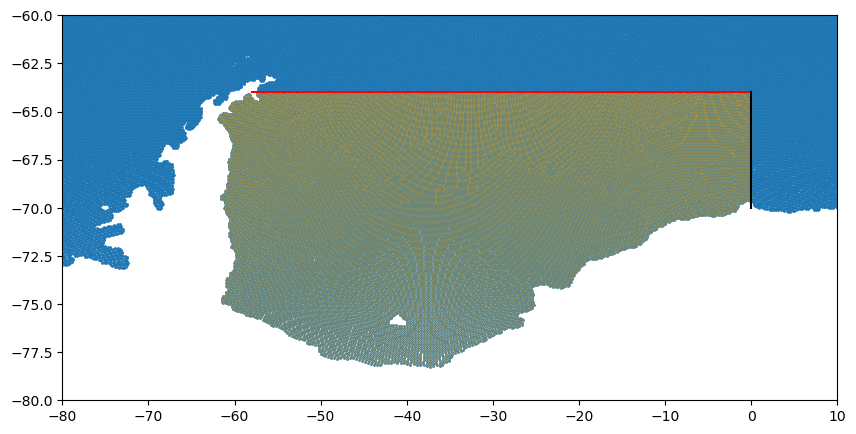

In [4]:
meshd = pf.load_mesh('/work/ba1264/a270210/model/input/fesom2/dart', usepickle=False)

sz_lat = [-70,-64]
sz_lon = [0,0]
sm_lat = [-64,-64]
sm_lon = [-58,0]

box=[-60.7, sm_lon[1], -80, sz_lat[1]]
left, right, down, up = box
mask_1 = ((meshd.x2 >= left) & 
           (meshd.x2 <= right) & 
           (meshd.y2 >= down) & 
           (meshd.y2 <= up))

box=[-62, -60.7, -80, -65]
left, right, down, up = box
mask_2 = ((meshd.x2 >= left) & 
           (meshd.x2 <= right) & 
           (meshd.y2 >= down) & 
           (meshd.y2 <= up))

mask_WS = mask_1 | mask_2

fig = plt.figure(figsize=(10,5))
#plt.scatter (meshd.x2[:], meshd.y2[:],s=1,edgecolors=None)
plt.scatter (x2[:], y2[:],s=1,edgecolors=None)
plt.scatter(x2[mask_WS], y2[mask_WS],s=1, color='orange', alpha=0.2, edgecolors=None)
plt.xlim([-80,10])
plt.ylim([-80,-60])
plt.plot(sm_lon,sm_lat, color='r')
plt.plot(sz_lon,sz_lat, color='k')

In [6]:
year1=1980
year2=1980
for year in range(year1, year2+1):
    print(year)
    data = xr.open_mfdataset(result_path+'u.fesom.'+str(year)+'.nc')
    u = data.u.values
    data.close()

    data = xr.open_mfdataset(result_path+'v.fesom.'+str(year)+'.nc')
    v = data.v.values
    data.close()

    #To compute volume transport 
    u = u.mean(axis=0)
    v = v.mean(axis=0)
    
    #To compute heat transport 
    #data = xr.open_mfdataset(result_path+'temp.fesom.'+str(year)+'.nc')
    #temp = data.temp.values
    #data.close()

    #temp_el = temp[:, :, mesh.elem].sum(axis=3)/3.

    #u = (u*temp_el).mean(axis=0)
    #v = (v*temp_el).mean(axis=0)
    
    print('computation complete')
    
    #Sections for zonal and meridional transport
    s1v = flux_into_section(sm_lon,sm_lat, u, v, meshd, ed_cros_lx, ed_cros_ly, ed_cros_rx, ed_cros_ry, dz)#*4190.*1025.*1.e-15
    print('meridional section')
    s1u = flux_into_section(sz_lon,sz_lat,  u, v, meshd, ed_cros_lx, ed_cros_ly, ed_cros_rx, ed_cros_ry, dz)#*4190.*1025.*1.e-15
    print('zonal section')
    
    section1v.append(s1v)
    section1u.append(s1u)

np.save('section1v_%s' %year1 + '-%s.npy' %year2, np.array(section1v))
np.save('section1u_%s' %year1 + '-%s.npy' %year2, np.array(section1u))

1980
computation complete
meridional section
zonal section


In [8]:
print(s1u.sum()*10**(-6), s1v.sum()*10**(-6), (s1u.sum()+s1v.sum())*10**(-6))

-32.716621880441735 32.48751718682153 -0.2291046936202049


In [9]:
year1=1980
year2=1980
lev=54
for year in range(year1, year2+1):
    print(year)
    data = xr.open_mfdataset(result_path+'w.fesom.'+str(year)+'.nc')
    w = data.w.values[:,:79]
    data.close()

    #To compute volume transport 
    #w = w.mean(axis=0)

    #To compute heat transport 
    data = xr.open_mfdataset(result_path+'temp.fesom.'+str(year)+'.nc')
    temp = data.temp.values
    data.close()

    w = (w*(temp+1.8)).mean(axis=0)
    
    s1w1 = vertical_flux([-62,0], [-80,-64], meshd, w, nod_area)
    #s1w2 = vertical_flux([-62,0], [-70,-64], meshd, w, nod_area)
    s1w = (w*nod_area[:79])[:,mask_WS].sum(axis=1)

1980


In [10]:
lev=56
a=s1u[:lev].sum()*10**(-6)
b=s1v[:lev].sum()*10**(-6)
c=s1w[lev-1]*10**(-6)
print(zbar[lev-1], a,b,c,a+b+c)

-2050.0 -20.395681659598708 20.00469283012511 0.264459936302952 -0.12652889317064725
